

*   Data: Resized 12-band or RGB images (resized ratio: 0.5, 0.5, 1)
*   Dimensionality reduction: PCA and LLE
*   Statistical models: Linear Regression and SVR
*   Methods:
      * Resized images are used to predict cases directly
      * Resized images first do PCA then use statistical models to predict cases
      * Resized images first do LLE then use statistical models to predict cases


# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup Environment and Load Functions

### Install library

In [ ]:
!pip install scikit-learn==0.24

     |████████████████████████████████| 22.3 MB 1.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1


In [ ]:
# sklearn library
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import linear_model  
from sklearn.svm import SVR

In [ ]:
from random import randint, randrange
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

import skimage
import cv2
import os
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
skimage.__version__

'0.18.3'

In [ ]:
!pip install epiweeks
from epiweeks import Week, Year
from datetime import date

### Get epi weeks

In [ ]:
def getEpiWeek(origin_str):
  """Get epi week from string
  """
  date_ls = origin_str.split('-')
  return Week.fromdate(date(int(date_ls[0]), int(date_ls[1]), int(date_ls[2])))

### Load CSV file

In [ ]:
def loadStructuredData(csv_path):
  df = pd.DataFrame()
  if os.path.isdir(csv_path):
    for filename in os.listdir(csv_path):
      file_path = os.path.join(csv_path, filename)
      df = df.append(pd.read_csv(file_path))
  elif os.path.isfile(csv_path):
    df = pd.read_csv(csv_path)
  else:
    print('Error: Not folder or file')
  return df

### Plot graphs 

In [ ]:
def plotData(x_asix, y_axis, title):
  plt.figure(figsize = (12, 8))
  plt.plot(x_axis, y_axis, color ='black')
  plt.ylabel('Dengue Cases')
  plt.title(title)
  plt.tick_params(axis='both',labelsize=3)
  plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')

  plt.show()

In [ ]:
def plotDistribution(corr_list, X_train, y_train):
  sorted_corr_list = list(corr_list)
  sorted_corr_list.sort(reverse=True)

  max_index = corr_list.index(sorted_corr_list[0])
  sec_max_index = corr_list.index(sorted_corr_list[1])

  color_list = []
  max_cases = max(y_train)

  for i in y_train:
    color = [i / max_cases, 0, 0]
    color_list.append(color)

  color_list = np.array(color_list)

  plt.subplot(1, 2, 1)
  plt.scatter(X_train[:,max_index], X_train[:,sec_max_index], c=color_list)
  plt.subplot(1, 2, 2)
  plt.scatter(np.full(y_train.shape, 0, dtype=int), y_train, c=color_list)
  plt.tight_layout()
  plt.show()

### Image

In [ ]:
def readImg(img_path, resize_ratio=None):
  img = io.imread(img_path)

  if resize_ratio:
    img_rescale = rescale(img, resize_ratio, anti_aliasing=True)

  print(os.path.basename(img_path), '(origin shape:', img.shape, '-> rescale:', str(img_rescale.shape) + ')')
  return img_rescale

### Split traing and testing set

In [ ]:
def splitTrainTestSet(ratio):
  # Split the data into training (ratio) and testing (1 - ratio)
  train_val_ratio = ratio
  train_num = int(len(info_dict['Image']) * train_val_ratio)

  # Change list to array
  origin_dimension_X = np.array(info_dict['Image'])
  labels = np.array(info_dict['cases_medellin'])

  print(''.center(60,'-'))

  origin_X_train = origin_dimension_X[:train_num,:,:,:]
  y_train = labels[:train_num]
  origin_X_test = origin_dimension_X[train_num:,:,:,:]
  y_test = labels[train_num:]

  print('Total number of weeks:'.ljust(30), len(origin_dimension_X), 'weeks')
  print('Training input:'.ljust(30), origin_X_train.shape)
  print('Training output:'.ljust(30), y_train.shape)
  print('Testing input:'.ljust(30), origin_X_test.shape)
  print('Testing output:'.ljust(30), y_test.shape) 

  return origin_X_train, y_train, origin_X_test, y_test

### Load csv and image data

In [ ]:
# Load data from one of the source
def loadData(csv_folder, img_folder, option=None, resize_ratio=None):
  if option is None:
    # Get data by combining from csv and images
    df = loadStructuredData(csv_folder)
    info_dict = combineData(img_folder, df, resize_ratio)
    
    print(len(info_dict['LastDayWeek']), len(info_dict['Image']), len(info_dict['cases_medellin']))

  else:
    # Load data from previous pickle file
    info_dict = loadDataFromPickle(option)
  return info_dict

In [ ]:
def combineData(img_folder, df, resize_ratio=None):
  info_dict = {'LastDayWeek':[], 'cases_medellin':[], 'Image':[], 'epi_week':[]}
  img_list = os.listdir(img_folder)

  for index, row in df.iterrows():
    name = row['LastDayWeek']
    week_df = str(getEpiWeek(name))
    case = row['cases_medellin']
    for img_name in img_list:
      
      # If image name is image_2017-12-24.tiff -> get 2017-12-24
      # Reference Links: https://www.w3schools.com/python/ref_string_join.asp, 
      #                  https://stackoverflow.com/questions/13174468/how-do-you-join-all-items-in-a-list/13175535
      new_img_name = ''.join(i for i in img_name if i.isdigit() or i == '-')      

      week_img = str(getEpiWeek(new_img_name))

      if week_df == week_img:
        img_path = os.path.join(img_folder, img_name)
        img = readImg(img_path, resize_ratio)

        info_dict['Image'].append(img)
        info_dict['LastDayWeek'].append(name)
        info_dict['cases_medellin'].append(case)
        info_dict['epi_week'].append(week_df)
        break

  return info_dict

### Dimensionality reduction - PCA

In [ ]:
def dimension_reduct_with_PCA(origin_X_train, origin_X_test, y_train):
  print(' PRINCIPAL COMPONENT ANALYSIS  '.center(100, '='))

  reshape_X_train = origin_X_train.reshape(origin_X_train.shape[0], -1)
  reshape_X_test = origin_X_test.reshape(origin_X_test.shape[0], -1)

  pca = PCA(n_components=0.95) 
  pca_X_train = pca.fit_transform(reshape_X_train)

  pca_X_test = pca.transform(reshape_X_test)
  print('Origin shape'.ljust(15), reshape_X_train.shape)
  print('Resize shape'.ljust(15), pca_X_train.shape)  

  return pca_X_train, pca_X_test

In [ ]:
def pca_per_band(origin_X_train, origin_X_test, y_train):
  pca_X_train = None
  pca_X_test = None
  for band in range(origin_X_train.shape[3]):
    pca_band_train, pca_band_test = dimension_reduct_with_PCA(origin_X_train, origin_X_test, y_train)
    if pca_X_train is None and pca_X_test is None:
      pca_X_train = pca_band_train
      pca_X_test = pca_band_test
    else:
      pca_X_train = np.append(pca_X_train, pca_band_train, axis = 1)
      pca_X_test = np.append(pca_X_test, pca_band_test, axis = 1)
  
  print(pca_X_train.shape, pca_X_test.shape)
  return pca_X_train, pca_X_test

### Dimensionality reduction - LLE

In [ ]:
def dimension_reduct_with_LLE(origin_X_train, origin_X_test, y_train):
  print(' LOCALLY LINEAR EMBEDDING '.center(100, '='))

  reshape_X_train = origin_X_train.reshape(origin_X_train.shape[0], -1)
  reshape_X_test = origin_X_test.reshape(origin_X_test.shape[0], -1)

  embedding = LocallyLinearEmbedding(n_components=2, neighbors_algorithm='kd_tree')
  lle_X_train = embedding.fit_transform(reshape_X_train, y_train)
  lle_X_test = embedding.transform(reshape_X_test)

  return lle_X_train, lle_X_test

### Model - LR

In [ ]:
def classified_with_LR(origin_X_train, origin_X_test, y_train, y_test):
  print('[Linear Regression]'.center(100, '-'))

  reshape_X_train = origin_X_train.reshape(origin_X_train.shape[0], -1)
  reshape_X_test = origin_X_test.reshape(origin_X_test.shape[0], -1)

  regr = linear_model.LinearRegression()
  regr.fit(reshape_X_train, y_train)

  float_y_pred = regr.predict(reshape_X_test)
  int_y_pred = [int(i) for i in float_y_pred]

  print('Predicted')
  print(' '.ljust(3, ' '), 'List =', int_y_pred)
  print(' '.ljust(3, ' '), 'Mean =', round(np.mean(int_y_pred), 4))
  print('')

  print('Real')
  print(' '.ljust(3, ' '), 'List =', y_test)
  print(' '.ljust(3, ' '), 'Mean =', round(np.mean(y_test), 4))
  print('')

  MAE = get_MAE_score(y_test, int_y_pred)
  MAPE = get_MAPE_score(y_test, int_y_pred)

  print('- MAE: ', str(MAE).rjust(8), '(cases different in average)')
  print('- MAPE:', str(MAPE).rjust(8), '(times different in average)')

  return MAE, MAPE

### Model - SVR

In [ ]:
def classified_with_SVR(origin_X_train, origin_X_test, y_train, y_test):
  print('[SVR]'.center(100, '-'))

  reshape_X_train = origin_X_train.reshape(origin_X_train.shape[0], -1)
  reshape_X_test = origin_X_test.reshape(origin_X_test.shape[0], -1)

  regressor = SVR(C=1.0, epsilon=0.2)
  regressor.fit(reshape_X_train, y_train)

  float_y_pred = regressor.predict(reshape_X_test)
  int_y_pred = [int(i) for i in float_y_pred]

  print('Predicted')
  print(' '.ljust(3, ' '), 'List =', int_y_pred)
  print(' '.ljust(3, ' '), 'Mean =', round(np.mean(int_y_pred), 4))
  print('')

  print('Real')
  print(' '.ljust(3, ' '), 'List =', y_test)
  print(' '.ljust(3, ' '), 'Mean =', round(np.mean(y_test), 4))
  print('')
  
  MAE = get_MAE_score(y_test, int_y_pred)
  MAPE = get_MAPE_score(y_test, int_y_pred)
  
  print('- MAE: ', str(MAE).rjust(8), '(cases different in average)')
  print('- MAPE:', str(MAPE).rjust(8), '(times different in average)')

  return MAE, MAPE

### Evaluation metrics

In [ ]:
def calCorrelation(data, label):
  corr = np.corrcoef(data, label)[0, 1]
  return round(corr, 4)

In [ ]:
def get_MAPE_score(y_true, y_pred):
  """Get Mean Absolute Percentage Error (MAPE)
  
  Calculate the MAPE score based on the prediction. 
  The lower MAPE socre is, the better the predictions are.

  """
  return round(mean_absolute_percentage_error(y_true, y_pred), 4)

In [ ]:
def get_MAE_score(y_test, y_pred):
  return round(mean_absolute_error(y_test, y_pred), 4)

# 12-band Images Run Here

In [ ]:
# Define main folder
dataset_folder = '/content/drive/MyDrive/Dengue forecasting with Satellite Images/dataset'

# Define image folder
image_name = 'image/image_12_band'
img_folder = os.path.join(dataset_folder, image_name)

# Define csv folder
csv_name = 'csv/merge_cases_timeseries.csv'
csv_folder = os.path.join(dataset_folder, csv_name)
info_dict = loadData(csv_folder, img_folder, resize_ratio=(0.5, 0.5, 1))

print('INFO_DICT'.center(50, '-'))
print('keys:', info_dict.keys())
print('')

print('DENGUE CASES'.center(50, '-'))
print('Max weekly dengue cases:', max(info_dict['cases_medellin']))
print('Min weekly dengue cases:', min(info_dict['cases_medellin']))
print('')

print('WEEKS'.center(50, '-'))
print('Max week:', max(info_dict['LastDayWeek']))
print('Min week:', min(info_dict['LastDayWeek']))

image_2015-11-01.tiff (origin shape: (1205, 765, 12) -> rescale: (602, 382, 12))
image_2015-11-08.tiff (origin shape: (1205, 765, 12) -> rescale: (602, 382, 12))
image_2015-11-15.tiff (origin shape: (1205, 765, 12) -> rescale: (602, 382, 12))
image_2015-11-22.tiff (origin shape: (1205, 765, 12) -> rescale: (602, 382, 12))
image_2015-11-29.tiff (origin shape: (1205, 765, 12) -> rescale: (602, 382, 12))
image_2015-12-06.tiff (origin shape: (1205, 765, 12) -> rescale: (602, 382, 12))
image_2015-12-13.tiff (origin shape: (1205, 765, 12) -> rescale: (602, 382, 12))
image_2015-12-20.tiff (origin shape: (1205, 765, 12) -> rescale: (602, 382, 12))
image_2015-12-27.tiff (origin shape: (1205, 765, 12) -> rescale: (602, 382, 12))
image_2016-01-03.tiff (origin shape: (1205, 765, 12) -> rescale: (602, 382, 12))
image_2016-01-10.tiff (origin shape: (1205, 765, 12) -> rescale: (602, 382, 12))
image_2016-01-17.tiff (origin shape: (1205, 765, 12) -> rescale: (602, 382, 12))
image_2016-01-24.tiff (origi

In [ ]:
print(info_dict['epi_week'])

['201544', '201545', '201546', '201547', '201548', '201549', '201550', '201551', '201552', '201601', '201602', '201603', '201604', '201605', '201606', '201607', '201608', '201609', '201610', '201611', '201612', '201613', '201614', '201615', '201616', '201617', '201618', '201619', '201620', '201621', '201622', '201623', '201624', '201625', '201626', '201627', '201628', '201629', '201630', '201631', '201632', '201633', '201634', '201635', '201636', '201637', '201638', '201639', '201640', '201641', '201642', '201643', '201644', '201645', '201646', '201647', '201648', '201649', '201650', '201651', '201701', '201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708', '201709', '201710', '201711', '201712', '201713', '201714', '201715', '201716', '201717', '201718', '201719', '201720', '201721', '201722', '201723', '201724', '201725', '201726', '201727', '201728', '201729', '201730', '201731', '201732', '201733', '201734', '201735', '201736', '201737', '201738', '201739',

## Data Distrubtion Visualization

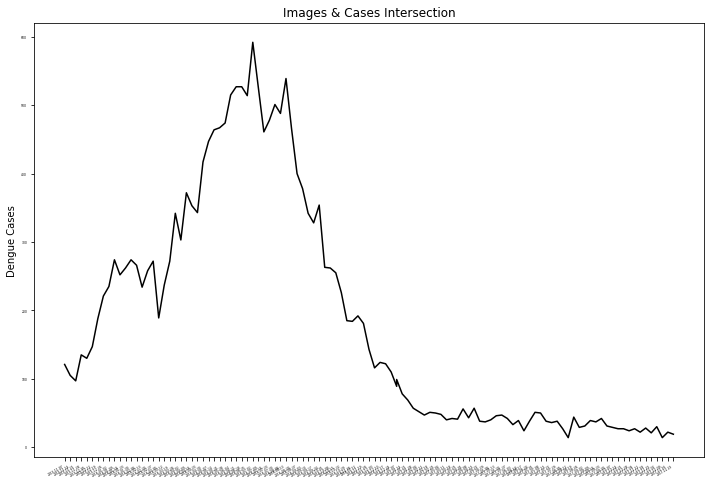

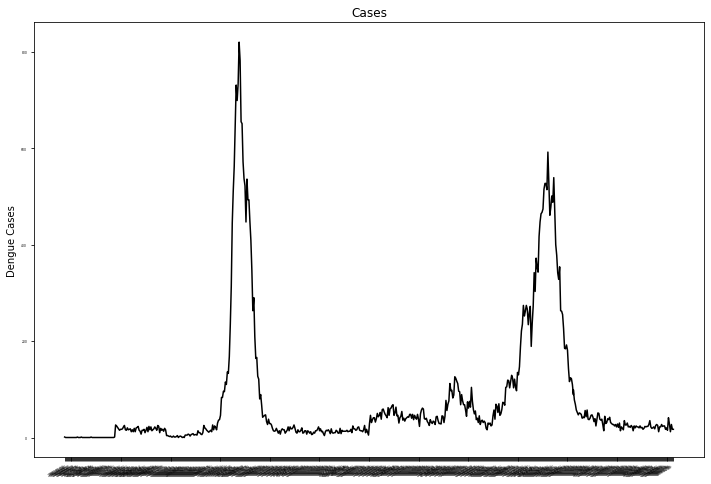

In [ ]:
x_axis = info_dict['LastDayWeek']
y_axis = info_dict['cases_medellin']
plotData(x_axis, y_axis, 'Images & Cases Intersection')

dataset_folder = '/content/drive/MyDrive/Dengue forecasting with Satellite Images/dataset'
csv_name = 'csv/merge_cases_timeseries.csv'
csv_folder = os.path.join(dataset_folder, csv_name)
df = loadStructuredData(csv_folder)

x_axis = df['LastDayWeek']
y_axis = df['cases_medellin'].astype(int)
plotData(x_axis, y_axis, 'Cases')

## Test Different Combination

### Resized images without dimensionality reduction

#### Split training and testing

In [ ]:
origin_X_train, y_train, origin_X_test, y_test = splitTrainTestSet(0.8)

------------------------------------------------------------
Total number of weeks:         112 weeks
Training input:                (89, 602, 382, 12)
Training output:               (89,)
Testing input:                 (23, 602, 382, 12)
Testing output:                (23,)


#### First two bands

In [ ]:
first_n_band = 2
print(' RESIZED IMAGE WITHOUT DIMENSIONALITY REDUCTION : FIRST TWO BANDS '.center(100, '='))

selected_X_train = origin_X_train[:, :, :, 0 : first_n_band]
selected_X_test = origin_X_test[:, :, :, 0 : first_n_band]

# LR
MAE, MAPE = classified_with_LR(selected_X_train, selected_X_test, y_train, y_test)
print('')

# SVR 
MAE, MAPE = classified_with_SVR(selected_X_train, selected_X_test, y_train, y_test)

================= RESIZED IMAGE WITHOUT DIMENSIONALITY REDUCTION : FIRST TWO BANDS =================
----------------------------------------[Linear Regression]-----------------------------------------
Predicted
    List = [1673354267770, -22868437251675, -22511634620422, 53247525538014, -34717885302216, 60361240856599, -1854869421725, 5505640077899, 5908017111515, 34384319654725, 30436979969638, 19855009194995, 71443527575209, 6359414614693, -5929351554176, 35048408419020, 34576089118802, 78356080951674, -5295705872468, 17230452648749, 5040743547260, 6505502744062, 6123983873921]
    Mean = 16472974180080.998

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  24575398877693.0 (cases different in average)
- MAPE: 939267873816.1606 (times different in average)
-----------------------------------------------[SVR]------------------------------------------------
Predicted
    List = [186, 188, 188, 188, 188, 188, 188, 188, 18

#### All bands

In [ ]:
print(' RESIZED IMAGE WITHOUT DIMENSIONALITY REDUCTION : ALL BANDS '.center(100, ' '))
print(''.center(100, '='))

# LR
MAE, MAPE = classified_with_LR(origin_X_train, origin_X_test, y_train, y_test)
print('')

# SVR 
MAE, MAPE = classified_with_SVR(origin_X_train, origin_X_test, y_train, y_test)

                     RESIZED IMAGE WITHOUT DIMENSIONALITY REDUCTION : ALL BANDS                     
----------------------------------------[Linear Regression]-----------------------------------------
Predicted
    List = [735232989636, -8526366323040, -7573519815685, -2014298661537, -5152719209312, -8184875211498, 2414704583652, 1990400237346, -739508613604, 1805136965051, -458509643996, 3625276638322, 199694233821, -12744980917998, -353607020319, -963618376628, 7141116572792, -8286923335743, -4222487707085, -7178973501072, -10382527796988, 4607948639208, 2255792122843]
    Mean = -2261200571818.8696

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  4415574744230.435 (cases different in average)
- MAPE: 176556141230.256 (times different in average)

-----------------------------------------------[SVR]------------------------------------------------
Predicted
    List = [186, 188, 187, 187, 187, 188, 187, 187, 186, 187,

### Resized images with PCA per bands

#### Perform dimensionality reduction

In [ ]:
first_n_band = 2
selected_X_train = origin_X_train[:, :, :, 0 : first_n_band]
selected_X_test = origin_X_test[:, :, :, 0 : first_n_band]

# First n bands
n_band_pca_separate_X_train, n_band_pca_separate_X_test = pca_per_band(selected_X_train, selected_X_test, y_train)

# All bands
all_band_pca_separate_X_train, all_band_pca_separate_X_test = pca_per_band(origin_X_train, origin_X_test, y_train)

================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (89, 459928)
Resize shape    (89, 39)
================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (89, 459928)
Resize shape    (89, 39)
(89, 78) (23, 78)
================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (89, 2759568)
Resize shape    (89, 27)
================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (89, 2759568)
Resize shape    (89, 27)
================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (89, 2759568)
Resize shape    (89, 27)
================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (89, 2759568)
Resize shape    (89, 27)
================================== PRINCIPAL COM

#### First two bands

In [ ]:
# Linear Regression
MAE, MAPE = classified_with_LR(n_band_pca_separate_X_train, n_band_pca_separate_X_test, y_train, y_test)
print('')

# SVR 
MAE, MAPE = classified_with_SVR(n_band_pca_separate_X_train, n_band_pca_separate_X_test, y_train, y_test)

----------------------------------------[Linear Regression]-----------------------------------------
Predicted
    List = [124, 263, 151, 170, 121, 133, 201, 187, 217, 218, 154, 151, 9, 118, 142, 92, 214, 84, 150, 230, 38, 93, 168]
    Mean = 149.0435

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:     122.0 (cases different in average)
- MAPE:   4.5055 (times different in average)
-----------------------------------------------[SVR]------------------------------------------------
Predicted
    List = [186, 189, 188, 188, 189, 189, 189, 188, 186, 189, 188, 188, 189, 189, 190, 188, 188, 187, 187, 187, 188, 188, 186]
    Mean = 188.0

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  159.3913 (cases different in average)
- MAPE:   6.1888 (times different in average)


#### All bands

In [ ]:
# Linear Regression
MAE, MAPE = classified_with_LR(all_band_pca_separate_X_train, all_band_pca_separate_X_test, y_train, y_test)
print('')

# SVR 
MAE, MAPE = classified_with_SVR(all_band_pca_separate_X_train, all_band_pca_separate_X_test, y_train, y_test)

----------------------------------------[Linear Regression]-----------------------------------------
Predicted
    List = [204, 206, 214, 237, 121, 209, 275, 252, 225, 264, 209, 198, -24, 207, -24, -4, 213, 28, 161, -50, 110, 147, 205]
    Mean = 155.7826

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  145.4348 (cases different in average)
- MAPE:   5.5311 (times different in average)
-----------------------------------------------[SVR]------------------------------------------------
Predicted
    List = [186, 189, 187, 187, 187, 188, 187, 187, 186, 187, 188, 187, 187, 189, 188, 186, 187, 186, 187, 187, 187, 187, 186]
    Mean = 187.087

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  158.4783 (cases different in average)
- MAPE:   6.1544 (times different in average)


### Resized images with PCA (all bands together)

#### Perform dimensionality reduction

In [ ]:
first_n_band = 2
selected_X_train = origin_X_train[:, :, :, 0 : first_n_band]
selected_X_test = origin_X_test[:, :, :, 0 : first_n_band]

# First n bands
n_band_pca_together_X_train, n_band_pca_together_X_test = dimension_reduct_with_PCA(selected_X_train, selected_X_test, y_train)

# All bands
all_band_pca_together_X_train, all_band_pca_together_X_test = dimension_reduct_with_PCA(origin_X_train, origin_X_test, y_train)

================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (89, 459928)
Resize shape    (89, 39)
================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (89, 2759568)
Resize shape    (89, 27)


#### First two bands

In [ ]:
# Linear Regression
MAE, MAPE = classified_with_LR(n_band_pca_together_X_train, n_band_pca_together_X_test, y_train, y_test)
print('')

# SVR 
MAE, MAPE = classified_with_SVR(n_band_pca_together_X_train, n_band_pca_together_X_test, y_train, y_test)

----------------------------------------[Linear Regression]-----------------------------------------
Predicted
    List = [124, 263, 151, 170, 121, 133, 201, 187, 217, 218, 154, 151, 9, 118, 142, 92, 215, 84, 149, 229, 38, 93, 168]
    Mean = 149.0

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  121.9565 (cases different in average)
- MAPE:    4.504 (times different in average)
-----------------------------------------------[SVR]------------------------------------------------
Predicted
    List = [186, 189, 188, 188, 189, 189, 189, 188, 186, 189, 188, 188, 189, 189, 190, 188, 188, 187, 187, 187, 188, 188, 186]
    Mean = 188.0

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  159.3913 (cases different in average)
- MAPE:   6.1888 (times different in average)


#### All bands

In [ ]:
# Linear Regression
MAE, MAPE = classified_with_LR(all_band_pca_together_X_train, all_band_pca_together_X_test, y_train, y_test)
print('')

# SVR 
MAE, MAPE = classified_with_SVR(all_band_pca_together_X_train, all_band_pca_together_X_test, y_train, y_test)

----------------------------------------[Linear Regression]-----------------------------------------
Predicted
    List = [204, 205, 214, 237, 122, 209, 275, 252, 225, 264, 208, 198, -24, 207, -24, -4, 213, 27, 162, -50, 110, 146, 205]
    Mean = 155.6957

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  145.4348 (cases different in average)
- MAPE:   5.5312 (times different in average)
-----------------------------------------------[SVR]------------------------------------------------
Predicted
    List = [186, 189, 187, 187, 187, 188, 187, 187, 186, 187, 188, 187, 187, 189, 188, 186, 187, 186, 187, 187, 187, 187, 186]
    Mean = 187.087

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  158.4783 (cases different in average)
- MAPE:   6.1544 (times different in average)


### Resized images with LLE

#### Perform LLE

In [ ]:
first_n_band = 2
selected_X_train = origin_X_train[:, :, :, 0 : first_n_band]
selected_X_test = origin_X_test[:, :, :, 0 : first_n_band]

# First n bands
n_band_lle_X_train, n_band_lle_X_test = dimension_reduct_with_LLE(selected_X_train, selected_X_test, y_train)

# All bands
all_band_lle_X_train, all_band_lle_X_test = dimension_reduct_with_LLE(origin_X_train, origin_X_test, y_train)

===================================== LOCALLY LINEAR EMBEDDING =====================================
===================================== LOCALLY LINEAR EMBEDDING =====================================


#### First 2 bands

In [ ]:
# Linear Regression
MAE, MAPE = classified_with_LR(n_band_lle_X_train, n_band_lle_X_test, y_train, y_test)

# SVR 
MAE, MAPE = classified_with_SVR(n_band_lle_X_train, n_band_lle_X_test, y_train, y_test)

----------------------------------------[Linear Regression]-----------------------------------------
Predicted
    List = [224, 220, 224, 224, 221, 223, 224, 224, 224, 224, 224, 224, 223, 220, 221, 224, 224, 224, 219, 219, 224, 224, 224]
    Mean = 222.8696

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  194.2609 (cases different in average)
- MAPE:    7.527 (times different in average)
-----------------------------------------------[SVR]------------------------------------------------
Predicted
    List = [188, 188, 187, 188, 188, 189, 187, 187, 188, 187, 187, 187, 189, 188, 188, 188, 188, 188, 188, 188, 187, 188, 188]
    Mean = 187.7826

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  159.1739 (cases different in average)
- MAPE:   6.1822 (times different in average)


#### All bands

In [ ]:
# Linear Regression
MAE, MAPE = classified_with_LR(all_band_lle_X_train, all_band_lle_X_test, y_train, y_test)

# SVR 
MAE, MAPE = classified_with_SVR(all_band_lle_X_train, all_band_lle_X_test, y_train, y_test)

----------------------------------------[Linear Regression]-----------------------------------------
Predicted
    List = [210, 239, 210, 215, 231, 228, 210, 210, 210, 210, 215, 210, 227, 239, 241, 219, 210, 206, 242, 242, 218, 215, 210]
    Mean = 220.3043

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  191.6957 (cases different in average)
- MAPE:    7.421 (times different in average)
-----------------------------------------------[SVR]------------------------------------------------
Predicted
    List = [184, 193, 184, 185, 192, 190, 184, 184, 184, 184, 185, 184, 190, 193, 193, 186, 184, 183, 192, 192, 186, 184, 184]
    Mean = 186.9565

Real
    List = [36 38 27 14 44 29 31 39 37 42 31 29 27 27 24 27 22 28 21 30 14 22 19]
    Mean = 28.6087

- MAE:  158.3478 (cases different in average)
- MAPE:   6.1455 (times different in average)


# RGB Images Run Here

## Read images

In [ ]:
# Define main folder
dataset_folder = '/content/drive/MyDrive/Dengue forecasting with Satellite Images/dataset'

# Define image folder
image_name = 'image/image_rgb'
img_folder = os.path.join(dataset_folder, image_name)

# Define csv folder
csv_name = 'csv/merge_cases_timeseries.csv'
csv_folder = os.path.join(dataset_folder, csv_name)
info_dict = loadData(csv_folder, img_folder, resize_ratio=(0.5, 0.5, 1))

print('INFO_DICT'.center(50, '-'))
print('keys:', info_dict.keys())
print('')

print('DENGUE CASES'.center(50, '-'))
print('Max weekly dengue cases:', max(info_dict['cases_medellin']))
print('Min weekly dengue cases:', min(info_dict['cases_medellin']))
print('')

print('WEEKS'.center(50, '-'))
print('Max week:', max(info_dict['LastDayWeek']))
print('Min week:', min(info_dict['LastDayWeek']))

image_2016-01-03.tiff (origin shape: (1205, 765, 3) -> rescale: (602, 382, 3))
image_2016-01-10.tiff (origin shape: (1205, 765, 3) -> rescale: (602, 382, 3))
image_2016-01-17.tiff (origin shape: (1205, 765, 3) -> rescale: (602, 382, 3))
image_2016-01-24.tiff (origin shape: (1205, 765, 3) -> rescale: (602, 382, 3))
image_2016-02-07.tiff (origin shape: (1205, 765, 3) -> rescale: (602, 382, 3))
image_2016-02-14.tiff (origin shape: (1205, 765, 3) -> rescale: (602, 382, 3))
image_2016-03-06.tiff (origin shape: (1205, 765, 3) -> rescale: (602, 382, 3))
image_2016-03-20.tiff (origin shape: (1205, 765, 3) -> rescale: (602, 382, 3))
image_2016-04-03.tiff (origin shape: (1205, 765, 3) -> rescale: (602, 382, 3))
image_2016-04-17.tiff (origin shape: (1205, 765, 3) -> rescale: (602, 382, 3))
image_2016-04-24.tiff (origin shape: (1205, 765, 3) -> rescale: (602, 382, 3))
image_2016-05-01.tiff (origin shape: (1205, 765, 3) -> rescale: (602, 382, 3))
image_2016-05-08.tiff (origin shape: (1205, 765, 3) 

In [ ]:
origin_X_train, y_train, origin_X_test, y_test = splitTrainTestSet(0.8)

------------------------------------------------------------
Total number of weeks:         145 weeks
Training input:                (116, 602, 382, 3)
Training output:               (116,)
Testing input:                 (29, 602, 382, 3)
Testing output:                (29,)


## Resized images without dimensionality reduction

In [ ]:
# LR
MAE, MAPE = classified_with_LR(origin_X_train, origin_X_test, y_train, y_test)
print('')

# SVR 
MAE, MAPE = classified_with_SVR(origin_X_train, origin_X_test, y_train, y_test)

----------------------------------------[Linear Regression]-----------------------------------------
Predicted
    List = [-263734540560, 5990493315302, 5087699576081, -316787402706, -10298217423965, -8051446612973, -2518859611867, 650306461787, 3167768225805, -3863527111602, -1989119808204, -5641552997999, 1029883611107, -1623059347266, 456420129330, 597979034726, -2472634171748, -1415306658159, 7807246345234, 4237288852588, -2358614228165, -4142858818420, -5168702371026, 1795326904732, -5858308221088, 3820330306055, 1927554290535, -5182760891799, 1772604048908]
    Mean = -787054797081.2759

Real
    List = [22 23 23 27 35 22 19 20 22 18 25 27 25 12 22 22 27 23 24 24 17 20 15 41
 28 12 27 17 17]
    Mean = 22.6207

- MAE:  3431254873096.1724 (cases different in average)
- MAPE: 158604687757.0361 (times different in average)

-----------------------------------------------[SVR]------------------------------------------------
Predicted
    List = [43, 43, 42, 42, 43, 44, 44, 43, 44, 43

## Resized images with PCA per band

In [ ]:
rgb_pca_separate_X_train, rgb_pca_separate_X_test = pca_per_band(origin_X_train, origin_X_test, y_train)

================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (116, 689892)
Resize shape    (116, 49)
================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (116, 689892)
Resize shape    (116, 49)
================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (116, 689892)
Resize shape    (116, 49)
(116, 147) (29, 147)


In [ ]:
# LR
MAE, MAPE = classified_with_LR(rgb_pca_separate_X_train, rgb_pca_separate_X_test, y_train, y_test)
print('')

# SVR 
MAE, MAPE = classified_with_SVR(rgb_pca_separate_X_train, rgb_pca_separate_X_test, y_train, y_test)

----------------------------------------[Linear Regression]-----------------------------------------
Predicted
    List = [190, 303, -39, 122, 90, 192, 305, 216, 255, 186, 107, 89, 71, 86, 114, 118, 161, 123, 102, 183, 104, 51, 27, 31, -30, 102, 247, 137, 127]
    Mean = 130.0

Real
    List = [22 23 23 27 35 22 19 20 22 18 25 27 25 12 22 22 27 23 24 24 17 20 15 41
 28 12 27 17 17]
    Mean = 22.6207

- MAE:  116.3448 (cases different in average)
- MAPE:   5.5302 (times different in average)

-----------------------------------------------[SVR]------------------------------------------------
Predicted
    List = [43, 44, 41, 42, 44, 44, 44, 43, 45, 44, 43, 45, 41, 41, 41, 42, 45, 43, 41, 43, 43, 41, 42, 42, 43, 44, 44, 44, 42]
    Mean = 42.8966

Real
    List = [22 23 23 27 35 22 19 20 22 18 25 27 25 12 22 22 27 23 24 24 17 20 15 41
 28 12 27 17 17]
    Mean = 22.6207

- MAE:   20.2759 (cases different in average)
- MAPE:   1.0333 (times different in average)


## Resized images with PCA (all bands together)

In [ ]:
rgb_pca_together_X_train, rgb_pca_pca_together_X_test = dimension_reduct_with_PCA(origin_X_train, origin_X_test, y_train)

================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (116, 689892)
Resize shape    (116, 49)


In [ ]:
# LR
MAE, MAPE = classified_with_LR(rgb_pca_together_X_train, rgb_pca_pca_together_X_test, y_train, y_test)
print('')

# SVR 
MAE, MAPE = classified_with_SVR(rgb_pca_together_X_train, rgb_pca_pca_together_X_test, y_train, y_test)

----------------------------------------[Linear Regression]-----------------------------------------
Predicted
    List = [190, 304, -39, 122, 90, 192, 305, 217, 255, 187, 107, 89, 70, 86, 114, 118, 162, 123, 102, 183, 104, 51, 27, 31, -30, 102, 246, 137, 127]
    Mean = 130.069

Real
    List = [22 23 23 27 35 22 19 20 22 18 25 27 25 12 22 22 27 23 24 24 17 20 15 41
 28 12 27 17 17]
    Mean = 22.6207

- MAE:  116.4138 (cases different in average)
- MAPE:   5.5339 (times different in average)

-----------------------------------------------[SVR]------------------------------------------------
Predicted
    List = [43, 44, 41, 42, 44, 44, 44, 43, 45, 44, 43, 45, 41, 41, 41, 42, 45, 43, 41, 43, 43, 41, 42, 42, 43, 44, 44, 44, 42]
    Mean = 42.8966

Real
    List = [22 23 23 27 35 22 19 20 22 18 25 27 25 12 22 22 27 23 24 24 17 20 15 41
 28 12 27 17 17]
    Mean = 22.6207

- MAE:   20.2759 (cases different in average)
- MAPE:   1.0333 (times different in average)


## Resized images with LLE

In [ ]:
rgb_lle_X_train, rgb_lle_X_test = dimension_reduct_with_LLE(origin_X_train, origin_X_test, y_train)

===================================== LOCALLY LINEAR EMBEDDING =====================================


In [ ]:
# LR
MAE, MAPE = classified_with_LR(rgb_lle_X_train, rgb_lle_X_test, y_train, y_test)
print('')

# SVR 
MAE, MAPE = classified_with_SVR(rgb_lle_X_train, rgb_lle_X_test, y_train, y_test)

----------------------------------------[Linear Regression]-----------------------------------------
Predicted
    List = [147, 123, 123, 123, 191, 187, 189, 123, 207, 138, 123, 232, 165, 165, 151, 151, 238, 158, 162, 157, 119, 145, 135, 121, 204, 165, 174, 130, 123]
    Mean = 157.5517

Real
    List = [22 23 23 27 35 22 19 20 22 18 25 27 25 12 22 22 27 23 24 24 17 20 15 41
 28 12 27 17 17]
    Mean = 22.6207

- MAE:   134.931 (cases different in average)
- MAPE:    6.386 (times different in average)

-----------------------------------------------[SVR]------------------------------------------------
Predicted
    List = [42, 42, 42, 42, 48, 47, 46, 42, 47, 42, 42, 48, 44, 44, 42, 42, 48, 43, 44, 43, 42, 42, 41, 42, 49, 44, 45, 41, 42]
    Mean = 43.7241

Real
    List = [22 23 23 27 35 22 19 20 22 18 25 27 25 12 22 22 27 23 24 24 17 20 15 41
 28 12 27 17 17]
    Mean = 22.6207

- MAE:   21.1034 (cases different in average)
- MAPE:    1.065 (times different in average)
